# BigTable MTLM for LOA
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [2]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 2


Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
generate_student_name()

'CHAFIC KODUM '

In [4]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [5]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
run_p_easiest = 0.99
run_p_hardest = 0.01

# max_atts = 10
# q_p_easiest = (1-(1-run_p_easiest)**(1/10))
# q_p_hardest = (1-(1-run_p_hardest)**(1/10))
q_p_easiest = run_p_easiest
q_p_hardest = run_p_hardest

# print("hazards:")
# print(q_p_easiest, q_p_hardest)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2


baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)


# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15

if theta_min < 0:
    beta_min -= theta_min
    beta_max -= theta_min
    theta_max -= theta_min
    theta_min -= theta_min


print("bs:",beta_min, beta_max)
print("ths:", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)

# print("worst Run Pr=", 1-(1-(worst_comp_pr**n_traits))**max_atts)
# print("best Run Pr=", 1-(1-(best_comp_pr**n_traits))**max_atts)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
bs: 1 4.744003674264945
ths: 2.5467790969287263 6.290782771193672
worst cmp chance= 0.10000000000000002
best cmp chance= 0.99498743710662
worst Pr= 0.010000000000000004
best Pr= 0.99
[[1 2 3]
 [7 8 9]]
(2, 3)


In [6]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)

        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [7]:
# class Question():
#     def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
#         #self.MAX_BETA = 15
#         mass = random.uniform(min_diff*nt,max_diff*nt)
# #         mass = random.choice([(0.8*min_diff+0.2*max_diff)*nt, 0.5*(min_diff+max_diff)*nt, (0.2*min_diff + 0.8*max_diff)*nt])
#         base = min_diff*nt
#         mass = mass - base
        
#         self.id = qix
# #         no_dummies = randint(1,(nt-1))
#         no_live = nt
# #         print("no_dummies=",no_dummies)
# #         self.betas = [ round(random.uniform(min_diff, max_diff),1) for _ in range(nt) ]

#         not_present= min_diff
#         self.betas = [ not_present for _ in range(nt) ]
#         choices = list(range(nt))
#         shuffle(choices)
#         while mass > 0:
#             for c in choices:
#                 curr = self.betas[c]
#                 if curr >= max_diff:
#                     continue
#                 slyce = min(random.uniform(0,max_diff-curr), mass)
#                 mass -= slyce
#                 self.betas[c] += slyce
#                 if mass <= 0:
#                     break    
                    
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

#         n_c = randint(1,nt)
        n_c = numpy.random.choice([1,2], p=[0.5,0.5])
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.betas[c] = random.uniform(min_diff, max_diff)

In [8]:
class Student():
    def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        mass = random.uniform(min_abil*nt,max_abil*nt)
        base = min_abil*nt
        mass = mass - base
        
        self.id = psix
        self.name = generate_student_name()
#         min_abil = 0
#         max_abil = 10
#         self.thetas = [ round(random.uniform(min_abil, max_abil),1) for _ in range(nt) ]
        not_present= min_abil
        self.thetas = [ not_present for _ in range(nt) ]
        choices = list(range(nt))
        shuffle(choices)
        while mass > 0:
            for c in choices:
                curr = self.thetas[c]
                if curr >= max_abil:
                    continue
                slyce = min(random.uniform(0,max_abil-curr), mass)
                mass -= slyce
                self.thetas[c] += slyce
                if mass <= 0:
                    break                  
    

In [9]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [10]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        if b == 0:
            p_pass_step = 1
        else:
            z = (th-b)
            p_pass_step = exp(z) / (1.0 + exp(z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [11]:
qopt = Adam()

# def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
#     random.seed(666)
#     master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
#     for q in master_qs:
#         nocomps = len(q.betas)
# #         mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
#         mag = sum(q.betas)
#         print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
    
#     for q in master_qs:
#         print("qid",q.id,q.betas)
    
#     qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
#     return master_qs, qn_table


def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=0, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [12]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    psi_attn_table = BigTable((n_students, 1), min_w=0, max_w=1)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [13]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
#             print("* * * **** USER {}".format(psi.name))
#             print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                while q_ct<user_patience:
                    q_ct+=1
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, (q_ct if passed else 0))
                    attempt_n_map[(q.id,psi.id)] += 1
                    if passed:
                        attempts.append(tup)
                        break
                    else:
                        print("**patience exceeded, spend is {}".format(spend+q_ct))
                
                print("p_pass was",pp) #, "run p:", 1-(1-pp)**max_atts)
                
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                                        
                if passed:
                    print("passed in",q_ct)
                    qs.remove(qix)

                spend += q_ct

                if spend>=user_budget:
                    print("****B exceeded w/ {} qns left".format(len(qs)))
                    break
                
                if qs == []:
                    print("no questions left")
                    break
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map



def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     did_pass = Input(shape=(1,), name="did_pass")
#     did_n = Input(shape=(1,), name="did_n")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: K.exp(z) / (1.0 + K.exp(z)), name="sPr_sigmoid")(dif)
    
    print("Prs",Prs.shape)
    #calculate the hazard rate here
    hz = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     print("hz",hz.shape)
    
    max_att = 10
    #calculate the prob of passing in <= max_att
    #prob of passing at point t:
    #Pr(X=t) = (1-p)^(t-1) * p # i.e. fail^(t-1), then pass 
    
#     Pr = (1-p)^(t-1) * p
    
    
#     hidden = Dense(5, activation="relu")(Prs)
#     hidden = Dense(5, activation="relu")(hidden)
#     hidden = Dense(5, activation="relu")(hidden)
#     n = Dense(1, activation="relu")(hidden)
    n = Lambda(lambda p: (1/p), name="n_calc")(hz)
    print("n",n.shape)
#     n = multiply([n, did_pass], name="n_cancellor")

#     print("did_pass", did_pass.shape)
    print("n'",n.shape)

#     hz = Lambda(lambda hz: tf.Print(hz, [hz], message="hz is:", first_n=-1, summarize=1024))(hz)
#     pazz = Lambda( lambda p : (1.0-K.pow((1-p),max_att)), name="pazz_calc" ) (hz)
#     pazz = Lambda(lambda t: tf.Print(t, [t], message="pazz is:", first_n=-1, summarize=1024))(pazz)

#     hidden2 = Dense(5, activation="relu")(Prs)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     pazz = Dense(1, activation="sigmoid")(hidden2)
#     print("pazz",pazz.shape)
    
#     model = Model(inputs=[qn_sel, psi_sel, did_pass], outputs=[pazz,n])
    model = Model(inputs=[qn_sel, psi_sel], outputs=[n,])
    model.compile(optimizer=optimiser, loss=["mse"], metrics=["accuracy"])#, loss_weights=[1.0,1.0])
    return model

In [14]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    numpy.random.seed(666)
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        av_th = (min_th + max_th)/2.0
#         psi_wgts[s.id,:] = numpy.random.uniform(max_th-1, max_th, size=psi_wgts.shape[1])
        psi_wgts[s.id,:] = numpy.random.uniform(min_th, max_th, size=psi_wgts.shape[1])

        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        av_b = (min_b + max_b)/2.0
#         qn_wgts[q.id,:]= numpy.random.uniform(min_b, min_b+1, size=qn_wgts.shape[1])
        qn_wgts[q.id,:]= numpy.random.uniform(min_b, max_b, size=qn_wgts.shape[1])

        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [15]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [16]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
#     ns = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    ns =array( [(attempt_n_map[(q,p)] if pf>0 else 0)  for (q,p,pf) in zip(qices, psices, pfs) ])
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs
    nz = ns

#     for pf in pfs:
#         print(pf)
    
    print(qz)
    print(sz)
    print(pfz)
    print(nz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):

        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=[nz,])#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])
#         s_model.fit(x=[qz, sz], y=pfz, epochs=1, shuffle=True, batch_size=1, callbacks=[es], verbose=1)

#         qs_model.fit(x=[qz, sz], y=pfz, epochs=100, shuffle=True, validation_split=0.1, batch_size=len(pfz), callbacks=[es], verbose=1)

        if i % 10 == 0:
            topn=20
            predz = qs_model.predict(x=[qices[0:topn], psices[0:topn]], verbose=0) 
            for j in range(topn):
                print(qices[j], psices[j], ns[j], ":", predz[j])

            tup = qs_model.evaluate(x=[qices, psices], y=[ns,], verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss2, mse2, acc2 = s_model.evaluate(x=[qices, psices], y=pfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss=(loss+loss2)/2
#             mse=(mse+mse2)/2
#             acc=(acc+acc2)/2
            mse, acc = tup
            tup = mse, acc, 0,0
            sub_h.append(tup)

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.mean( numpy.abs(s_thetas - s_wgts) )
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.mean( numpy.abs(q_betas - q_wgts) )
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
#             print(loss,pf_loss,mse,acc, n_acc)
            print(mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2],sub_h[-1,3])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse =(th_rmse+b_rmse)/2.0
            av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_LOA_natts_only.hdf5")
                print("...model saved")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break

    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


Q:0, difficulty=5.11 across 2 components
Q:1, difficulty=4.04 across 1 components
Q:2, difficulty=3.95 across 2 components
Q:3, difficulty=2.44 across 1 components
Q:4, difficulty=4.34 across 1 components
Q:5, difficulty=1.06 across 1 components
Q:6, difficulty=3.81 across 2 components
Q:7, difficulty=5.53 across 2 components
Q:8, difficulty=3.63 across 1 components
Q:9, difficulty=1.32 across 1 components
Q:10, difficulty=3.97 across 2 components
Q:11, difficulty=5.29 across 2 components
Q:12, difficulty=3.76 across 1 components
Q:13, difficulty=1.57 across 2 components
Q:14, difficulty=3.36 across 2 components
Q:15, difficulty=1.13 across 1 components
Q:16, difficulty=5.33 across 2 components
Q:17, difficulty=6.02 across 2 components
Q:18, difficulty=2.99 across 1 components
Q:19, difficulty=4.47 across 1 components
Q:20, difficulty=4.80 across 2 components
Q:21, difficulty=3.91 across 1 components
Q:22, difficulty=5.15 across 2 components
Q:23, difficulty=3.95 across 2 components
Q:

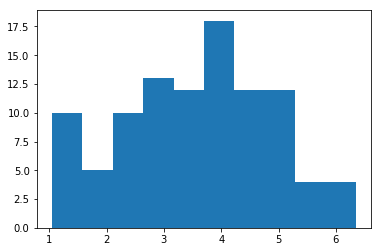

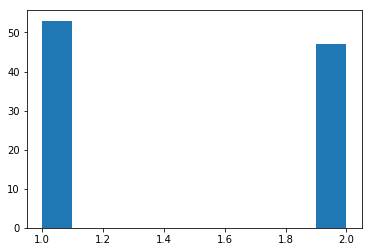

qid 0 [4.382045207550709, 2.626303456145134]
qid 1 [0, 4.037732889636235]
qid 2 [1.461044451595881, 3.6663849490381155]
qid 3 [0, 2.4432897289252216]
qid 4 [4.338998651656148, 0]
qid 5 [1.0627688047436565, 0]
qid 6 [3.5517369077821197, 1.3720800473515755]
qid 7 [4.450694561513504, 3.285761569798471]
qid 8 [3.6302155639603364, 0]
qid 9 [1.3233283595299397, 0]
qid 10 [3.3221811298581194, 2.16495695690213]
qid 11 [2.9787497024648903, 4.374192113230391]
qid 12 [0, 3.7598776002361176]
qid 13 [1.0522456405500955, 1.171746324398086]
qid 14 [2.7258814469267234, 1.9585963946199083]
qid 15 [0, 1.1288556694421505]
qid 16 [2.8756700368521875, 4.482189993857696]
qid 17 [4.440221935192133, 4.060817932467588]
qid 18 [0, 2.9914230219825573]
qid 19 [0, 4.472664360969149]
qid 20 [4.616351007731508, 1.3076033221339838]
qid 21 [0, 3.9148625678498927]
qid 22 [4.349432910757972, 2.759851657510133]
qid 23 [2.892687081035672, 2.6917365755118947]
qid 24 [4.307646806726926, 0]
qid 25 [3.039712298159648, 2.29678

p_pass was 0.7397956910845562
passed in 1
p_pass was 0.6244387931892578
passed in 1
p_pass was 0.8264163266779254
passed in 1
**patience exceeded, spend is 14
p_pass was 0.7950740492788215
passed in 2
p_pass was 0.9058859079220032
passed in 1
p_pass was 0.9645904724270644
passed in 1
**patience exceeded, spend is 18
**patience exceeded, spend is 19
**patience exceeded, spend is 20
**patience exceeded, spend is 21
p_pass was 0.11480350827419797
passed in 5
**patience exceeded, spend is 23
p_pass was 0.4170791628494081
passed in 2
**patience exceeded, spend is 25
**patience exceeded, spend is 26
**patience exceeded, spend is 27
**patience exceeded, spend is 28
**patience exceeded, spend is 29
**patience exceeded, spend is 30
**patience exceeded, spend is 31
**patience exceeded, spend is 32
**patience exceeded, spend is 33
**patience exceeded, spend is 34
p_pass was 0.2993398634662873
p_pass was 0.6782350205995137
passed in 1
**patience exceeded, spend is 36
p_pass was 0.5372877947019294


p_pass was 0.9213452369604321
passed in 1
p_pass was 0.9689764414934371
passed in 1
p_pass was 0.9480647075106837
passed in 1
p_pass was 0.9343562220329972
passed in 1
p_pass was 0.9584374500799753
passed in 1
p_pass was 0.8793867629592403
passed in 1
p_pass was 0.9400621634139481
passed in 1
p_pass was 0.9940104232061517
passed in 1
p_pass was 0.9597757485707938
passed in 1
p_pass was 0.9911417651347598
passed in 1
p_pass was 0.774806786425904
passed in 1
p_pass was 0.8360030313712988
passed in 1
p_pass was 0.9636074871465384
passed in 1
p_pass was 0.9296429381509497
passed in 1
p_pass was 0.9441276739922075
passed in 1
p_pass was 0.9738933279323062
passed in 1
p_pass was 0.9766888012423438
passed in 1
p_pass was 0.8756262594374058
passed in 1
p_pass was 0.9943756732292948
passed in 1
p_pass was 0.9883774704894311
passed in 1
p_pass was 0.9070203065023594
passed in 1
p_pass was 0.9250909400290658
passed in 1
p_pass was 0.9099182363250455
passed in 1
p_pass was 0.8848662288738945
passe

**patience exceeded, spend is 455
**patience exceeded, spend is 456
**patience exceeded, spend is 457
**patience exceeded, spend is 458
**patience exceeded, spend is 459
p_pass was 0.039678092863908436
**patience exceeded, spend is 460
**patience exceeded, spend is 461
**patience exceeded, spend is 462
**patience exceeded, spend is 463
**patience exceeded, spend is 464
**patience exceeded, spend is 465
**patience exceeded, spend is 466
**patience exceeded, spend is 467
**patience exceeded, spend is 468
**patience exceeded, spend is 469
p_pass was 0.039678092863908436
**patience exceeded, spend is 470
**patience exceeded, spend is 471
**patience exceeded, spend is 472
**patience exceeded, spend is 473
**patience exceeded, spend is 474
**patience exceeded, spend is 475
**patience exceeded, spend is 476
**patience exceeded, spend is 477
**patience exceeded, spend is 478
**patience exceeded, spend is 479
p_pass was 0.039678092863908436
**patience exceeded, spend is 480
**patience exceeded,

p_pass was 0.8936145243971171
passed in 1
p_pass was 0.9002615892583408
passed in 1
p_pass was 0.5987732187446227
passed in 1
p_pass was 0.7067349810995633
passed in 1
**patience exceeded, spend is 81
p_pass was 0.6489229256306761
passed in 2
p_pass was 0.9405095022400825
passed in 1
p_pass was 0.8568632400879671
passed in 1
**patience exceeded, spend is 85
**patience exceeded, spend is 86
p_pass was 0.9042446695828056
passed in 3
**patience exceeded, spend is 88
**patience exceeded, spend is 89
**patience exceeded, spend is 90
**patience exceeded, spend is 91
p_pass was 0.44046464869264607
passed in 5
**patience exceeded, spend is 93
p_pass was 0.8921493212377136
passed in 2
p_pass was 0.9504979099923407
passed in 1
**patience exceeded, spend is 96
**patience exceeded, spend is 97
p_pass was 0.47225291900869
passed in 3
p_pass was 0.9907747772421888
passed in 1
p_pass was 0.6817334695799777
passed in 1
**patience exceeded, spend is 101
p_pass was 0.9133800861587351
passed in 2
p_pass 

passed in 1
p_pass was 0.9713337365611305
passed in 1
p_pass was 0.9778076218964161
passed in 1
p_pass was 0.9834407617458472
passed in 1
p_pass was 0.8893660787522644
passed in 1
p_pass was 0.9346131195681042
passed in 1
p_pass was 0.8532781242075067
passed in 1
p_pass was 0.7517640215310283
passed in 1
p_pass was 0.9391249257445285
passed in 1
p_pass was 0.896115702202155
passed in 1
p_pass was 0.8332994046312312
passed in 1
p_pass was 0.9421766110375077
passed in 1
p_pass was 0.8829348404772815
passed in 1
p_pass was 0.7667158860279645
passed in 1
p_pass was 0.9737575940259876
passed in 1
p_pass was 0.9314386486510947
passed in 1
p_pass was 0.8596860876412752
passed in 1
p_pass was 0.7403265845082225
passed in 1
p_pass was 0.9914242998651667
passed in 1
p_pass was 0.992709161369304
passed in 1
**patience exceeded, spend is 39
p_pass was 0.7938044864432637
passed in 2
**patience exceeded, spend is 41
p_pass was 0.9607002918657289
passed in 2
p_pass was 0.7403169635153034
passed in 1


p_pass was 0.8663184306005371
passed in 1
p_pass was 0.8946593768938
passed in 1
p_pass was 0.6670075824674627
passed in 1
p_pass was 0.8674586698435023
passed in 1
p_pass was 0.6387506927451229
passed in 1
**patience exceeded, spend is 59
p_pass was 0.9106053593024698
passed in 2
p_pass was 0.9812206446118171
passed in 1
p_pass was 0.9419604609010261
passed in 1
p_pass was 0.8698703328131328
passed in 1
p_pass was 0.934380190923795
passed in 1
p_pass was 0.9223737325868818
passed in 1
p_pass was 0.7933283446839862
passed in 1
**patience exceeded, spend is 67
p_pass was 0.6977883486820917
passed in 2
p_pass was 0.8913849883091195
passed in 1
p_pass was 0.8111654427860314
passed in 1
p_pass was 0.902575664583519
passed in 1
p_pass was 0.7064204999017822
passed in 1
p_pass was 0.9806214283998148
passed in 1
p_pass was 0.9862039089525242
passed in 1
p_pass was 0.6645742256684992
passed in 1
p_pass was 0.9325003046640334
passed in 1
p_pass was 0.8270897691807688
passed in 1
p_pass was 0.94

p_pass was 0.8927149510203906
passed in 1
**patience exceeded, spend is 93
p_pass was 0.5435356301434606
passed in 2
p_pass was 0.8961730733217582
passed in 1
p_pass was 0.9934127359412067
passed in 1
p_pass was 0.9499359864819885
passed in 1
p_pass was 0.5813584798218364
passed in 1
p_pass was 0.7727812018739463
passed in 1
p_pass was 0.3474866986198309
passed in 1
**patience exceeded, spend is 101
p_pass was 0.3103361826106614
passed in 2
p_pass was 0.7196869901343788
passed in 1
p_pass was 0.8953671186311555
passed in 1
p_pass was 0.46708724435763993
passed in 1
**patience exceeded, spend is 106
**patience exceeded, spend is 107
**patience exceeded, spend is 108
**patience exceeded, spend is 109
**patience exceeded, spend is 110
**patience exceeded, spend is 111
**patience exceeded, spend is 112
p_pass was 0.4125395508644277
passed in 8
p_pass was 0.8285091266527758
passed in 1
**patience exceeded, spend is 115
p_pass was 0.5508015695582796
passed in 2
p_pass was 0.8705187262913555


p_pass was 0.7206345715529282
passed in 1
p_pass was 0.9289382402209303
passed in 1
p_pass was 0.8844725274865523
passed in 1
p_pass was 0.9331471835218268
passed in 1
p_pass was 0.9898678922067905
passed in 1
p_pass was 0.9741648083632886
passed in 1
**patience exceeded, spend is 22
p_pass was 0.8258912666822841
passed in 2
p_pass was 0.877569634039698
passed in 1
p_pass was 0.9334297599483404
passed in 1
p_pass was 0.8455586775241182
passed in 1
p_pass was 0.9198904700853668
passed in 1
p_pass was 0.734150135663176
passed in 1
p_pass was 0.9892130775084153
passed in 1
p_pass was 0.7224409620868533
passed in 1
p_pass was 0.7501177699575823
passed in 1
p_pass was 0.9889982352984277
passed in 1
p_pass was 0.9483512578594299
passed in 1
p_pass was 0.983223036631353
passed in 1
p_pass was 0.9424269446320658
passed in 1
p_pass was 0.9602354537234669
passed in 1
p_pass was 0.8230719701858576
passed in 1
p_pass was 0.8305822833758983
passed in 1
p_pass was 0.776900405488194
passed in 1
p_pas

passed in 1
**patience exceeded, spend is 25
**patience exceeded, spend is 26
**patience exceeded, spend is 27
**patience exceeded, spend is 28
**patience exceeded, spend is 29
**patience exceeded, spend is 30
**patience exceeded, spend is 31
p_pass was 0.2904482854364132
passed in 8
**patience exceeded, spend is 33
**patience exceeded, spend is 34
**patience exceeded, spend is 35
p_pass was 0.14688465947146984
passed in 4
**patience exceeded, spend is 37
p_pass was 0.7258448731804851
passed in 2
p_pass was 0.9830646193083066
passed in 1
p_pass was 0.4688511455719477
passed in 1
**patience exceeded, spend is 41
**patience exceeded, spend is 42
**patience exceeded, spend is 43
**patience exceeded, spend is 44
**patience exceeded, spend is 45
**patience exceeded, spend is 46
**patience exceeded, spend is 47
**patience exceeded, spend is 48
**patience exceeded, spend is 49
**patience exceeded, spend is 50
p_pass was 0.09807150025875469
p_pass was 0.6580870937106036
passed in 1
p_pass was 

p_pass was 0.8195740307312591
passed in 1
p_pass was 0.8597025229769476
passed in 1
p_pass was 0.7870370771510683
passed in 1
**patience exceeded, spend is 11
**patience exceeded, spend is 12
p_pass was 0.5142856962650384
passed in 3
p_pass was 0.9867895012376697
passed in 1
**patience exceeded, spend is 15
**patience exceeded, spend is 16
p_pass was 0.6539977505548782
passed in 3
p_pass was 0.9183842931267023
passed in 1
p_pass was 0.9287339151567926
passed in 1
p_pass was 0.7964602861326174
passed in 1
**patience exceeded, spend is 21
**patience exceeded, spend is 22
**patience exceeded, spend is 23
p_pass was 0.6312962033369944
passed in 4
p_pass was 0.8087834896316364
passed in 1
p_pass was 0.5712010679471891
passed in 1
p_pass was 0.9521942779338929
passed in 1
p_pass was 0.8713916945115127
passed in 1
p_pass was 0.8197512782102337
passed in 1
p_pass was 0.9788843087062816
passed in 1
p_pass was 0.9702353094243928
passed in 1
**patience exceeded, spend is 32
**patience exceeded, s

passed in 5
p_pass was 0.5430752168729162
passed in 1
p_pass was 0.8186312486648036
passed in 1
p_pass was 0.5661490855205213
passed in 1
**patience exceeded, spend is 511
p_pass was 0.4072358123501253
passed in 2
**patience exceeded, spend is 513
**patience exceeded, spend is 514
**patience exceeded, spend is 515
**patience exceeded, spend is 516
**patience exceeded, spend is 517
**patience exceeded, spend is 518
**patience exceeded, spend is 519
**patience exceeded, spend is 520
**patience exceeded, spend is 521
**patience exceeded, spend is 522
p_pass was 0.024297799719094085
**patience exceeded, spend is 523
p_pass was 0.525748808447305
passed in 2
**patience exceeded, spend is 525
**patience exceeded, spend is 526
**patience exceeded, spend is 527
**patience exceeded, spend is 528
**patience exceeded, spend is 529
**patience exceeded, spend is 530
**patience exceeded, spend is 531
**patience exceeded, spend is 532
**patience exceeded, spend is 533
**patience exceeded, spend is 534

passed in 1
p_pass was 0.8531756437036166
passed in 1
**patience exceeded, spend is 111
**patience exceeded, spend is 112
p_pass was 0.341396354441971
passed in 3
**patience exceeded, spend is 114
p_pass was 0.7867892679881713
passed in 2
p_pass was 0.6250846105230555
passed in 1
p_pass was 0.22331595455192516
passed in 1
**patience exceeded, spend is 118
p_pass was 0.5988023598956056
passed in 2
**patience exceeded, spend is 120
p_pass was 0.6446541969033934
passed in 2
p_pass was 0.6373176035411631
passed in 1
p_pass was 0.5282343291022153
passed in 1
**patience exceeded, spend is 124
**patience exceeded, spend is 125
**patience exceeded, spend is 126
p_pass was 0.7204988130043473
passed in 4
**patience exceeded, spend is 128
**patience exceeded, spend is 129
**patience exceeded, spend is 130
**patience exceeded, spend is 131
p_pass was 0.4364197330613945
passed in 5
p_pass was 0.8986847676816745
passed in 1
**patience exceeded, spend is 134
p_pass was 0.8787809134813737
passed in 2


p_pass was 0.9511981301727866
passed in 1
**patience exceeded, spend is 24
p_pass was 0.8928246974285319
passed in 2
**patience exceeded, spend is 26
p_pass was 0.7623960043861812
passed in 2
p_pass was 0.7662972051918107
passed in 1
p_pass was 0.9794062058253501
passed in 1
p_pass was 0.8961239670599077
passed in 1
p_pass was 0.8900074683456181
passed in 1
p_pass was 0.9793842637213425
passed in 1
p_pass was 0.8680803134335586
passed in 1
p_pass was 0.9559182442144838
passed in 1
p_pass was 0.9609421873305097
passed in 1
p_pass was 0.6505386888009017
passed in 1
p_pass was 0.7730780818926066
passed in 1
p_pass was 0.9321177044180802
passed in 1
p_pass was 0.8095117915938979
passed in 1
p_pass was 0.7811310770238996
passed in 1
p_pass was 0.9835596920847703
passed in 1
p_pass was 0.9483273110247761
passed in 1
p_pass was 0.8712536405176368
passed in 1
p_pass was 0.7488795578133297
passed in 1
p_pass was 0.8311452130911234
passed in 1
p_pass was 0.8563734144082538
passed in 1
p_pass was

passed in 6
p_pass was 0.1131551405241295
passed in 1
p_pass was 0.47586251896842574
passed in 1
p_pass was 0.6130066494987421
passed in 1
p_pass was 0.7080122207245624
passed in 1
p_pass was 0.7196742294047411
passed in 1
p_pass was 0.41059013205574063
passed in 1
p_pass was 0.4470696221093173
passed in 1
p_pass was 0.4780925273854441
passed in 1
**patience exceeded, spend is 45
**patience exceeded, spend is 46
**patience exceeded, spend is 47
**patience exceeded, spend is 48
p_pass was 0.12720671904420383
passed in 5
**patience exceeded, spend is 50
**patience exceeded, spend is 51
p_pass was 0.02899331053073858
passed in 3
p_pass was 0.6322350745442773
passed in 1
p_pass was 0.6923800382092236
passed in 1
**patience exceeded, spend is 55
p_pass was 0.1918030455484602
passed in 2
p_pass was 0.8448257495001863
passed in 1
**patience exceeded, spend is 58
**patience exceeded, spend is 59
**patience exceeded, spend is 60
**patience exceeded, spend is 61
**patience exceeded, spend is 62


p_pass was 0.13595910551014598
p_pass was 0.9542371985514593
passed in 1
**patience exceeded, spend is 329
**patience exceeded, spend is 330
**patience exceeded, spend is 331
**patience exceeded, spend is 332
**patience exceeded, spend is 333
**patience exceeded, spend is 334
**patience exceeded, spend is 335
**patience exceeded, spend is 336
**patience exceeded, spend is 337
**patience exceeded, spend is 338
p_pass was 0.1421643101479023
**patience exceeded, spend is 339
**patience exceeded, spend is 340
**patience exceeded, spend is 341
**patience exceeded, spend is 342
**patience exceeded, spend is 343
**patience exceeded, spend is 344
**patience exceeded, spend is 345
**patience exceeded, spend is 346
**patience exceeded, spend is 347
**patience exceeded, spend is 348
p_pass was 0.13595910551014598
**patience exceeded, spend is 349
**patience exceeded, spend is 350
**patience exceeded, spend is 351
p_pass was 0.13595910551014598
passed in 4
**patience exceeded, spend is 353
**patie

p_pass was 0.7258448731804851
passed in 2
**patience exceeded, spend is 52
**patience exceeded, spend is 53
**patience exceeded, spend is 54
**patience exceeded, spend is 55
**patience exceeded, spend is 56
p_pass was 0.09147348460822528
passed in 6
**patience exceeded, spend is 58
**patience exceeded, spend is 59
p_pass was 0.5105775571932215
passed in 3
**patience exceeded, spend is 61
p_pass was 0.7854992664670596
passed in 2
p_pass was 0.45645879359459784
passed in 1
**patience exceeded, spend is 64
**patience exceeded, spend is 65
p_pass was 0.35627507192904
passed in 3
**patience exceeded, spend is 67
**patience exceeded, spend is 68
p_pass was 0.1466816985822656
passed in 3
p_pass was 0.8677481941775557
passed in 1
p_pass was 0.8000693056730939
passed in 1
p_pass was 0.6895993604648618
passed in 1
**patience exceeded, spend is 73
**patience exceeded, spend is 74
p_pass was 0.07973103439894975
passed in 3
**patience exceeded, spend is 76
**patience exceeded, spend is 77
**patienc

p_pass was 0.8529872637344441
passed in 1
**patience exceeded, spend is 113
p_pass was 0.44056855261660066
passed in 2
p_pass was 0.3995922906762783
passed in 1
p_pass was 0.9393780719961794
passed in 1
p_pass was 0.6685180298131492
passed in 1
p_pass was 0.9598086193130717
passed in 1
p_pass was 0.8668105555848031
passed in 1
p_pass was 0.7138704439187826
passed in 1
p_pass was 0.8395014204550679
passed in 1
p_pass was 0.9158931165044685
passed in 1
p_pass was 0.9471111195959947
passed in 1
p_pass was 0.35844531851939065
passed in 1
p_pass was 0.8001559172880917
passed in 1
p_pass was 0.4752173308813116
passed in 1
**patience exceeded, spend is 127
**patience exceeded, spend is 128
p_pass was 0.5150154624969471
passed in 3
p_pass was 0.8844682235119218
passed in 1
p_pass was 0.7775542788405225
passed in 1
**patience exceeded, spend is 132
**patience exceeded, spend is 133
**patience exceeded, spend is 134
**patience exceeded, spend is 135
**patience exceeded, spend is 136
**patience e

passed in 1
p_pass was 0.7595763505925375
passed in 1
**patience exceeded, spend is 115
p_pass was 0.8905242389334428
passed in 2
p_pass was 0.7544589571089979
passed in 1
**patience exceeded, spend is 118
p_pass was 0.8667457029104788
passed in 2
p_pass was 0.8922307458027536
passed in 1
**patience exceeded, spend is 121
p_pass was 0.8369181305434099
passed in 2
p_pass was 0.9229863061889072
passed in 1
p_pass was 0.9678070503515961
passed in 1
p_pass was 0.7825116621357276
passed in 1
no questions left
**patience exceeded, spend is 1
p_pass was 0.8385896773171541
passed in 2
**patience exceeded, spend is 3
**patience exceeded, spend is 4
**patience exceeded, spend is 5
p_pass was 0.1154484024744806
passed in 4
p_pass was 0.5318794052495713
passed in 1
p_pass was 0.7801069169948402
passed in 1
p_pass was 0.827004786056606
passed in 1
p_pass was 0.18423710422426878
passed in 1
**patience exceeded, spend is 11
**patience exceeded, spend is 12
p_pass was 0.2662710702347858
passed in 3
p_

p_pass was 0.8381129481971157
passed in 1
p_pass was 0.8376669221455545
passed in 1
p_pass was 0.9103108300818672
passed in 1
**patience exceeded, spend is 47
p_pass was 0.9127268485320312
passed in 2
p_pass was 0.949182894439281
passed in 1
p_pass was 0.9643886946998905
passed in 1
**patience exceeded, spend is 51
p_pass was 0.884918019936159
passed in 2
p_pass was 0.9756682120140077
passed in 1
p_pass was 0.86027668668319
passed in 1
p_pass was 0.965137403367009
passed in 1
p_pass was 0.9317517663316096
passed in 1
p_pass was 0.830901488080787
passed in 1
p_pass was 0.9791016357898444
passed in 1
p_pass was 0.966446196612462
passed in 1
p_pass was 0.8245235308896781
passed in 1
**patience exceeded, spend is 61
p_pass was 0.8506622991981327
passed in 2
p_pass was 0.7215934588171188
passed in 1
p_pass was 0.9941359454061557
passed in 1
p_pass was 0.9712392337148844
passed in 1
p_pass was 0.8685449859223578
passed in 1
p_pass was 0.9924037334748672
passed in 1
p_pass was 0.9379388836965

p_pass was 0.31059224511015143
passed in 7
p_pass was 0.41674451329498485
passed in 1
p_pass was 0.7583176715897033
passed in 1
**patience exceeded, spend is 99
**patience exceeded, spend is 100
**patience exceeded, spend is 101
**patience exceeded, spend is 102
**patience exceeded, spend is 103
**patience exceeded, spend is 104
**patience exceeded, spend is 105
**patience exceeded, spend is 106
**patience exceeded, spend is 107
**patience exceeded, spend is 108
p_pass was 0.10569514436740023
**patience exceeded, spend is 109
**patience exceeded, spend is 110
**patience exceeded, spend is 111
p_pass was 0.40756666101399824
passed in 4
p_pass was 0.47741266210120453
passed in 1
p_pass was 0.4855637923491325
passed in 1
p_pass was 0.4836718585911014
passed in 1
**patience exceeded, spend is 116
p_pass was 0.5054972183093766
passed in 2
**patience exceeded, spend is 118
p_pass was 0.5633839915910929
passed in 2
**patience exceeded, spend is 120
**patience exceeded, spend is 121
**patience

p_pass was 0.6600328337799407
passed in 2
**patience exceeded, spend is 300
**patience exceeded, spend is 301
**patience exceeded, spend is 302
**patience exceeded, spend is 303
**patience exceeded, spend is 304
p_pass was 0.21033172761933064
passed in 6
**patience exceeded, spend is 306
**patience exceeded, spend is 307
**patience exceeded, spend is 308
**patience exceeded, spend is 309
**patience exceeded, spend is 310
**patience exceeded, spend is 311
**patience exceeded, spend is 312
**patience exceeded, spend is 313
**patience exceeded, spend is 314
**patience exceeded, spend is 315
p_pass was 0.1492430978410171
**patience exceeded, spend is 316
**patience exceeded, spend is 317
**patience exceeded, spend is 318
**patience exceeded, spend is 319
**patience exceeded, spend is 320
**patience exceeded, spend is 321
**patience exceeded, spend is 322
p_pass was 0.2132740866366799
passed in 8
**patience exceeded, spend is 324
p_pass was 0.1611994872220284
passed in 2
p_pass was 0.727564

passed in 2
**patience exceeded, spend is 68
**patience exceeded, spend is 69
p_pass was 0.3739081118372029
passed in 3
p_pass was 0.48286160433673103
passed in 1
p_pass was 0.36340773736183174
passed in 1
p_pass was 0.324113052657607
passed in 1
p_pass was 0.1627632578495204
passed in 1
**patience exceeded, spend is 75
**patience exceeded, spend is 76
**patience exceeded, spend is 77
**patience exceeded, spend is 78
p_pass was 0.17994292901065523
passed in 5
p_pass was 0.9180356850227286
passed in 1
**patience exceeded, spend is 81
**patience exceeded, spend is 82
**patience exceeded, spend is 83
**patience exceeded, spend is 84
**patience exceeded, spend is 85
**patience exceeded, spend is 86
**patience exceeded, spend is 87
p_pass was 0.36572725298010506
passed in 8
**patience exceeded, spend is 89
**patience exceeded, spend is 90
**patience exceeded, spend is 91
**patience exceeded, spend is 92
p_pass was 0.16712713871584486
passed in 5
**patience exceeded, spend is 94
**patience e

p_pass was 0.6950983875512456
passed in 2
**patience exceeded, spend is 38
p_pass was 0.8226007817713179
passed in 2
p_pass was 0.9137139053488608
passed in 1
**patience exceeded, spend is 41
**patience exceeded, spend is 42
p_pass was 0.6174475981429888
passed in 3
p_pass was 0.9211329988120687
passed in 1
**patience exceeded, spend is 45
p_pass was 0.6884024041156257
passed in 2
p_pass was 0.6640019593954931
passed in 1
**patience exceeded, spend is 48
p_pass was 0.7975428488816844
passed in 2
p_pass was 0.9204568340748905
passed in 1
p_pass was 0.989244095450693
passed in 1
p_pass was 0.8589963062946926
passed in 1
**patience exceeded, spend is 53
**patience exceeded, spend is 54
p_pass was 0.7036890793019568
passed in 3
p_pass was 0.8688441258917763
passed in 1
p_pass was 0.9577381361733811
passed in 1
p_pass was 0.745621943773471
passed in 1
p_pass was 0.9388815890207549
passed in 1
p_pass was 0.6063490278031328
passed in 1
p_pass was 0.7911228474866112
passed in 1
p_pass was 0.65

passed in 1
**patience exceeded, spend is 188
**patience exceeded, spend is 189
**patience exceeded, spend is 190
**patience exceeded, spend is 191
**patience exceeded, spend is 192
**patience exceeded, spend is 193
p_pass was 0.15020432303572287
passed in 7
p_pass was 0.5591759812264433
passed in 1
p_pass was 0.8377411734373277
passed in 1
p_pass was 0.6865942196752175
passed in 1
p_pass was 0.9128273745348121
passed in 1
p_pass was 0.7178326119122341
passed in 1
p_pass was 0.6083251116060155
passed in 1
p_pass was 0.8851408383912497
passed in 1
p_pass was 0.30911142285837806
passed in 1
p_pass was 0.2876678608130531
passed in 1
**patience exceeded, spend is 204
p_pass was 0.4554045987700548
passed in 2
p_pass was 0.754329114590222
passed in 1
no questions left
p_pass was 0.8029531029976871
passed in 1
p_pass was 0.8007661274323516
passed in 1
p_pass was 0.41280660525506596
passed in 1
p_pass was 0.8659353144309466
passed in 1
p_pass was 0.4638891359548493
passed in 1
p_pass was 0.769

p_pass was 0.9588598857782517
passed in 1
p_pass was 0.8524282296179736
passed in 1
p_pass was 0.9754232564861964
passed in 1
p_pass was 0.8449423291767868
passed in 1
p_pass was 0.9864961715199523
passed in 1
p_pass was 0.941441875588372
passed in 1
p_pass was 0.8941904703428641
passed in 1
p_pass was 0.7860107673823169
passed in 1
p_pass was 0.9499305812300982
passed in 1
p_pass was 0.6929839713605767
passed in 1
p_pass was 0.7807802017758957
passed in 1
p_pass was 0.8957677733752724
passed in 1
p_pass was 0.887822168075144
passed in 1
p_pass was 0.9811173596341437
passed in 1
p_pass was 0.7365303769534755
passed in 1
p_pass was 0.8791386928530484
passed in 1
**patience exceeded, spend is 55
**patience exceeded, spend is 56
p_pass was 0.5985510850618455
passed in 3
p_pass was 0.7816855194661434
passed in 1
p_pass was 0.8716594594278492
passed in 1
**patience exceeded, spend is 60
p_pass was 0.7207643397875516
passed in 2
**patience exceeded, spend is 62
p_pass was 0.7200824526089042


passed in 1
p_pass was 0.9000276684406464
passed in 1
p_pass was 0.6673412705731504
passed in 1
p_pass was 0.8760349659884151
passed in 1
p_pass was 0.4319193769148124
passed in 1
**patience exceeded, spend is 120
p_pass was 0.49081937916145624
passed in 2
**patience exceeded, spend is 122
**patience exceeded, spend is 123
**patience exceeded, spend is 124
**patience exceeded, spend is 125
**patience exceeded, spend is 126
**patience exceeded, spend is 127
p_pass was 0.23511085471459445
passed in 7
p_pass was 0.8451349344940576
passed in 1
**patience exceeded, spend is 130
**patience exceeded, spend is 131
p_pass was 0.3734702722694569
passed in 3
**patience exceeded, spend is 133
**patience exceeded, spend is 134
**patience exceeded, spend is 135
**patience exceeded, spend is 136
**patience exceeded, spend is 137
**patience exceeded, spend is 138
**patience exceeded, spend is 139
**patience exceeded, spend is 140
p_pass was 0.21837961034059516
passed in 9
**patience exceeded, spend is

passed in 1
p_pass was 0.8014813106976706
passed in 1
**patience exceeded, spend is 91
p_pass was 0.9522683561435445
passed in 2
**patience exceeded, spend is 93
p_pass was 0.48519565115830554
passed in 2
p_pass was 0.5405352734155281
passed in 1
**patience exceeded, spend is 96
**patience exceeded, spend is 97
p_pass was 0.3670026325507777
passed in 3
p_pass was 0.9354985163284784
passed in 1
**patience exceeded, spend is 100
p_pass was 0.7097167483267969
passed in 2
**patience exceeded, spend is 102
**patience exceeded, spend is 103
**patience exceeded, spend is 104
**patience exceeded, spend is 105
**patience exceeded, spend is 106
**patience exceeded, spend is 107
**patience exceeded, spend is 108
**patience exceeded, spend is 109
**patience exceeded, spend is 110
**patience exceeded, spend is 111
p_pass was 0.22257578267578135
p_pass was 0.9604631226448116
passed in 1
p_pass was 0.7173505493209108
passed in 1
p_pass was 0.8871472030170012
passed in 1
**patience exceeded, spend is 

passed in 1
**patience exceeded, spend is 29
p_pass was 0.8384371614407818
passed in 2
p_pass was 0.7973947705852804
passed in 1
**patience exceeded, spend is 32
p_pass was 0.6414036203801965
passed in 2
p_pass was 0.7702962759715394
passed in 1
p_pass was 0.9722788650257638
passed in 1
p_pass was 0.9194148882519585
passed in 1
**patience exceeded, spend is 37
**patience exceeded, spend is 38
p_pass was 0.7514101736382993
passed in 3
p_pass was 0.8721753976180615
passed in 1
p_pass was 0.6656477417241398
passed in 1
p_pass was 0.7789863058402716
passed in 1
**patience exceeded, spend is 43
p_pass was 0.759214104829808
passed in 2
p_pass was 0.6948036772729296
passed in 1
p_pass was 0.9711830630439119
passed in 1
p_pass was 0.961531023291214
passed in 1
p_pass was 0.9676157734377406
passed in 1
p_pass was 0.9132151132946968
passed in 1
p_pass was 0.7618454224533353
passed in 1
p_pass was 0.9538406829727967
passed in 1
**patience exceeded, spend is 52
p_pass was 0.8314025203717639
passed

**patience exceeded, spend is 202
**patience exceeded, spend is 203
**patience exceeded, spend is 204
p_pass was 0.19364689114090297
p_pass was 0.5471796839660993
passed in 1
**patience exceeded, spend is 206
p_pass was 0.4628314112930932
passed in 2
**patience exceeded, spend is 208
p_pass was 0.2945439800415305
passed in 2
p_pass was 0.35304242259513596
passed in 1
**patience exceeded, spend is 211
**patience exceeded, spend is 212
**patience exceeded, spend is 213
**patience exceeded, spend is 214
p_pass was 0.4527647229678223
passed in 5
**patience exceeded, spend is 216
p_pass was 0.14413406288856118
passed in 2
p_pass was 0.9627551899013477
passed in 1
p_pass was 0.7660908731062862
passed in 1
**patience exceeded, spend is 220
**patience exceeded, spend is 221
**patience exceeded, spend is 222
**patience exceeded, spend is 223
**patience exceeded, spend is 224
**patience exceeded, spend is 225
**patience exceeded, spend is 226
**patience exceeded, spend is 227
**patience exceeded

**patience exceeded, spend is 144
**patience exceeded, spend is 145
**patience exceeded, spend is 146
**patience exceeded, spend is 147
**patience exceeded, spend is 148
**patience exceeded, spend is 149
**patience exceeded, spend is 150
p_pass was 0.07707541484957539
passed in 9
p_pass was 0.2194180737172713
passed in 1
**patience exceeded, spend is 153
**patience exceeded, spend is 154
**patience exceeded, spend is 155
**patience exceeded, spend is 156
**patience exceeded, spend is 157
p_pass was 0.42663156807469077
passed in 6
p_pass was 0.1974536099296947
passed in 1
**patience exceeded, spend is 160
**patience exceeded, spend is 161
**patience exceeded, spend is 162
p_pass was 0.24081063654988522
passed in 4
p_pass was 0.5489466831080949
passed in 1
p_pass was 0.4389657788619902
passed in 1
**patience exceeded, spend is 166
**patience exceeded, spend is 167
p_pass was 0.20820429711288674
passed in 3
**patience exceeded, spend is 169
**patience exceeded, spend is 170
**patience exc

**patience exceeded, spend is 257
**patience exceeded, spend is 258
p_pass was 0.0640935338875569
passed in 7
p_pass was 0.8791532397558637
passed in 1
**patience exceeded, spend is 261
**patience exceeded, spend is 262
**patience exceeded, spend is 263
**patience exceeded, spend is 264
**patience exceeded, spend is 265
**patience exceeded, spend is 266
**patience exceeded, spend is 267
p_pass was 0.15155927056025084
passed in 8
p_pass was 0.5277969359559789
passed in 1
p_pass was 0.7258448731804851
passed in 1
p_pass was 0.763248329127672
passed in 1
**patience exceeded, spend is 272
**patience exceeded, spend is 273
**patience exceeded, spend is 274
p_pass was 0.23722079966154547
passed in 4
p_pass was 0.7324252764553177
passed in 1
**patience exceeded, spend is 277
p_pass was 0.25285624821794267
passed in 2
**patience exceeded, spend is 279
p_pass was 0.4880183510735143
passed in 2
p_pass was 0.7925295273790142
passed in 1
**patience exceeded, spend is 282
p_pass was 0.5906803373778

p_pass was 0.2672381104553065
p_pass was 0.23468895970590983
passed in 1
p_pass was 0.4755294155155441
passed in 1
**patience exceeded, spend is 275
**patience exceeded, spend is 276
**patience exceeded, spend is 277
p_pass was 0.04760383291859075
passed in 4
**patience exceeded, spend is 279
p_pass was 0.3700053155709945
passed in 2
**patience exceeded, spend is 281
p_pass was 0.22873538268875343
passed in 2
p_pass was 0.2672381104553065
passed in 1
p_pass was 0.6977374811616688
passed in 1
**patience exceeded, spend is 285
**patience exceeded, spend is 286
**patience exceeded, spend is 287
**patience exceeded, spend is 288
**patience exceeded, spend is 289
**patience exceeded, spend is 290
**patience exceeded, spend is 291
p_pass was 0.2455356727390018
passed in 8
**patience exceeded, spend is 293
p_pass was 0.4400813085039519
passed in 2
p_pass was 0.8341413833786931
passed in 1
**patience exceeded, spend is 296
p_pass was 0.3374349094299845
passed in 2
**patience exceeded, spend is

passed in 1
p_pass was 0.9545008326574479
passed in 1
p_pass was 0.6948597898768636
passed in 1
p_pass was 0.8840478381734431
passed in 1
p_pass was 0.9437713640966695
passed in 1
p_pass was 0.9755425942582429
passed in 1
p_pass was 0.9425504901058849
passed in 1
p_pass was 0.80909056682924
passed in 1
p_pass was 0.9245112060647996
passed in 1
p_pass was 0.7665195746073015
passed in 1
p_pass was 0.973475151818113
passed in 1
**patience exceeded, spend is 85
p_pass was 0.5888022825452344
passed in 2
p_pass was 0.9882492676175864
passed in 1
p_pass was 0.9565190187184675
passed in 1
p_pass was 0.9482983262246625
passed in 1
**patience exceeded, spend is 90
p_pass was 0.7102329306420764
passed in 2
p_pass was 0.9787667022352573
passed in 1
p_pass was 0.9105768214953825
passed in 1
p_pass was 0.8823164823655791
passed in 1
p_pass was 0.9678182645755815
passed in 1
p_pass was 0.9848047397954303
passed in 1
**patience exceeded, spend is 97
p_pass was 0.889423397535235
passed in 2
p_pass was 

passed in 2
**patience exceeded, spend is 79
**patience exceeded, spend is 80
**patience exceeded, spend is 81
**patience exceeded, spend is 82
p_pass was 0.5730006925976759
passed in 5
p_pass was 0.9459127214762447
passed in 1
**patience exceeded, spend is 85
p_pass was 0.6588902841397181
passed in 2
p_pass was 0.9055314141245001
passed in 1
p_pass was 0.9251487781372422
passed in 1
**patience exceeded, spend is 89
**patience exceeded, spend is 90
**patience exceeded, spend is 91
p_pass was 0.3241030949662818
passed in 4
**patience exceeded, spend is 93
p_pass was 0.4973540902100655
passed in 2
**patience exceeded, spend is 95
**patience exceeded, spend is 96
p_pass was 0.444806486459297
passed in 3
p_pass was 0.6903855504883261
passed in 1
p_pass was 0.35370951322469135
passed in 1
p_pass was 0.5741730843710655
passed in 1
**patience exceeded, spend is 101
p_pass was 0.9156379560306237
passed in 2
**patience exceeded, spend is 103
p_pass was 0.4053247866442882
passed in 2
p_pass was 

**patience exceeded, spend is 182
p_pass was 0.3530022273327305
passed in 2
**patience exceeded, spend is 184
**patience exceeded, spend is 185
**patience exceeded, spend is 186
p_pass was 0.8924524608611465
passed in 4
**patience exceeded, spend is 188
p_pass was 0.41562426742984415
passed in 2
p_pass was 0.937364158932053
passed in 1
p_pass was 0.8171146824565888
passed in 1
p_pass was 0.5609784699199869
passed in 1
**patience exceeded, spend is 193
**patience exceeded, spend is 194
p_pass was 0.28595427468747076
passed in 3
**patience exceeded, spend is 196
p_pass was 0.6580870937106036
passed in 2
**patience exceeded, spend is 198
p_pass was 0.0986123617937074
passed in 2
**patience exceeded, spend is 200
p_pass was 0.7428447327117136
passed in 2
p_pass was 0.19671934549203168
passed in 1
**patience exceeded, spend is 203
p_pass was 0.14112412940885277
passed in 2
**patience exceeded, spend is 205
**patience exceeded, spend is 206
**patience exceeded, spend is 207
**patience exceed

passed in 1
p_pass was 0.9148830730667017
passed in 1
p_pass was 0.6501591304790105
passed in 1
p_pass was 0.9504789415721551
passed in 1
p_pass was 0.835907778655905
passed in 1
p_pass was 0.9750484883119259
passed in 1
**patience exceeded, spend is 7
**patience exceeded, spend is 8
p_pass was 0.5946461319625201
passed in 3
p_pass was 0.8965178079653531
passed in 1
p_pass was 0.8570050170252558
passed in 1
p_pass was 0.4636253504949055
passed in 1
p_pass was 0.8698541461987694
passed in 1
p_pass was 0.9095615939528476
passed in 1
p_pass was 0.9563180920830564
passed in 1
p_pass was 0.5148509874794186
passed in 1
p_pass was 0.9221707495744124
passed in 1
p_pass was 0.8520977394811265
passed in 1
p_pass was 0.9597304276687085
passed in 1
p_pass was 0.7025253859293566
passed in 1
p_pass was 0.9643673484085078
passed in 1
p_pass was 0.9659509085125703
passed in 1
p_pass was 0.96867813080703
passed in 1
p_pass was 0.8333769316866607
passed in 1
**patience exceeded, spend is 25
**patience e

p_pass was 0.7258448731804851
passed in 3
p_pass was 0.31231578341166205
passed in 1
p_pass was 0.04723735444848554
passed in 1
p_pass was 0.2088970921711134
passed in 1
p_pass was 0.9422506470717347
passed in 1
**patience exceeded, spend is 330
**patience exceeded, spend is 331
**patience exceeded, spend is 332
**patience exceeded, spend is 333
p_pass was 0.14526879407588786
passed in 5
**patience exceeded, spend is 335
**patience exceeded, spend is 336
**patience exceeded, spend is 337
**patience exceeded, spend is 338
**patience exceeded, spend is 339
**patience exceeded, spend is 340
**patience exceeded, spend is 341
**patience exceeded, spend is 342
**patience exceeded, spend is 343
**patience exceeded, spend is 344
p_pass was 0.058160352028312705
p_pass was 0.6998043906266572
passed in 1
**patience exceeded, spend is 346
p_pass was 0.4688511455719477
passed in 2
p_pass was 0.08302285609913254
passed in 1
**patience exceeded, spend is 349
**patience exceeded, spend is 350
**patien

**patience exceeded, spend is 101
**patience exceeded, spend is 102
**patience exceeded, spend is 103
p_pass was 0.28785412790266285
passed in 5
**patience exceeded, spend is 105
p_pass was 0.3520382576588569
passed in 2
p_pass was 0.9586741805293884
passed in 1
p_pass was 0.8736853645133116
passed in 1
p_pass was 0.8248589328238065
passed in 1
p_pass was 0.3763472987693404
passed in 1
p_pass was 0.8479120009452069
passed in 1
**patience exceeded, spend is 112
**patience exceeded, spend is 113
p_pass was 0.5280844808134997
passed in 3
p_pass was 0.7752521626889459
passed in 1
p_pass was 0.307938948120252
passed in 1
p_pass was 0.7439175980572198
passed in 1
p_pass was 0.5423656155602135
passed in 1
**patience exceeded, spend is 119
p_pass was 0.7591375535524338
passed in 2
p_pass was 0.7491736205006991
passed in 1
**patience exceeded, spend is 122
p_pass was 0.7530022823521093
passed in 2
p_pass was 0.8286408636475828
passed in 1
**patience exceeded, spend is 125
**patience exceeded, s

KeyboardInterrupt: 

In [17]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 100
n_students = 1000
opt = Adam(lr=0.5) #try 0.5 for 2 dim

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=opt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=opt)
    attempts, attempts_by_q, attempts_by_psi, attempt_n_map = generate_attempts(qs,ss)
    
    pf = [tup[2] for tup in attempts]
    N = len(pf)
    pN = sum(pf)
    pr = pN/N
    
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     input("chunt")    psi_wgts = s_table.get_weights()[0]
#     qn_wgts = q_table.get_weights()[0]

#     print("pass rate is {} of {} = {}".format(pN,N,pr))
#     for _ in range(10):
#         print("*")
#     input("yam")


    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=1000000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_LOA_natts_only.hdf5")

    

elements in h: 153
(29.506539187717141, 0.39890999999999999, 0.0, 0.0)
(17.225181623908281, 0.59762000000000004, 0.0, 0.0)
(15.920887300195695, 0.58535000000000004, 0.0, 0.0)
(15.426131364948601, 0.57630999999999999, 0.0, 0.0)
(15.128687376915366, 0.57233000000000001, 0.0, 0.0)
(14.90453593360126, 0.56569999999999998, 0.0, 0.0)
(14.786221923318207, 0.56327000000000005, 0.0, 0.0)
(14.674062324353159, 0.56259999999999999, 0.0, 0.0)
(14.591869367134869, 0.56367999999999996, 0.0, 0.0)
(14.555064544942677, 0.56467999999999996, 0.0, 0.0)
(14.530895560093224, 0.56332000000000004, 0.0, 0.0)
(14.517047902394831, 0.56369000000000002, 0.0, 0.0)
(14.509838649086655, 0.56298000000000004, 0.0, 0.0)
(14.503820163153112, 0.56213000000000002, 0.0, 0.0)
(14.499007564654351, 0.56130999999999998, 0.0, 0.0)
(14.494545353076756, 0.56011999999999995, 0.0, 0.0)
(14.491880182435214, 0.55908999999999998, 0.0, 0.0)
(14.489609755263924, 0.55844000000000005, 0.0, 0.0)
(14.486984321126341, 0.55764000000000002, 0.0,

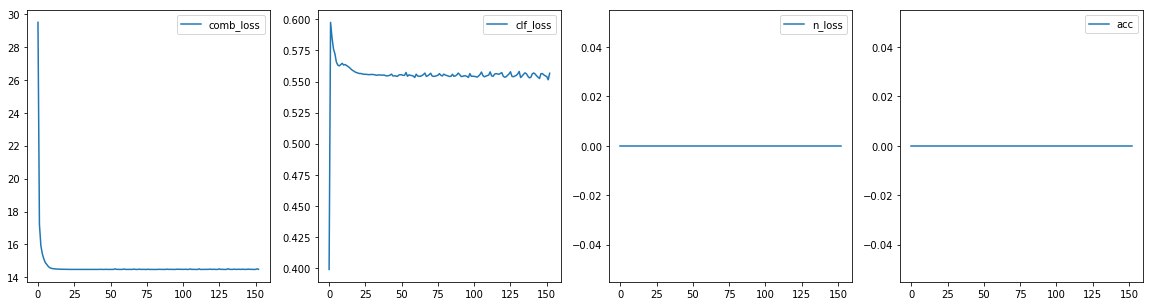

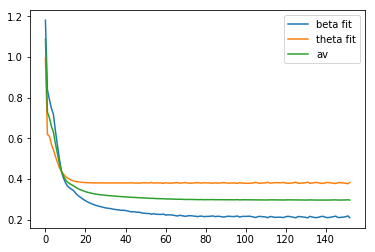

In [120]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

comb_loss, clf_loss, n_loss, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].plot(comb_loss, label="comb_loss")
axes[1].plot(clf_loss, label="clf_loss")
axes[2].plot(n_loss, label="n_loss")
axes[3].plot(acc, label="acc")

fig.set_size_inches(20, 5)
for i in [0,1,2,3]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [121]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 4.38204521  2.62630346]
 [ 0.          4.03773289]
 [ 1.46104445  3.66638495]
 [ 0.          2.44328973]
 [ 4.33899865  0.        ]
 [ 1.0627688   0.        ]
 [ 3.55173691  1.37208005]
 [ 4.45069456  3.28576157]
 [ 3.63021556  0.        ]
 [ 1.32332836  0.        ]
 [ 3.32218113  2.16495696]
 [ 2.9787497   4.37419211]
 [ 0.          3.7598776 ]
 [ 1.05224564  1.17174632]
 [ 2.72588145  1.95859639]
 [ 0.          1.12885567]
 [ 2.87567004  4.48218999]
 [ 4.44022194  4.06081793]
 [ 0.          2.99142302]
 [ 0.          4.47266436]
 [ 4.61635101  1.30760332]
 [ 0.          3.91486257]
 [ 4.34943291  2.75985166]
 [ 2.89268708  2.69173658]
 [ 4.30764681  0.        ]
 [ 3.0397123   2.29678002]
 [ 0.          2.93674834]
 [ 0.          3.2072676 ]
 [ 2.74323506  0.        ]
 [ 2.76603377  1.80531898]
 [ 4.3060262   0.        ]
 [ 3.635032    0.        ]
 [ 3.91071382  4.70886649]
 [ 2.85314824  4.41319806]
 [ 2.59471487  0.        ]
 [ 2.12925782  2.35965513]
 [ 1.94375486  1.157611

In [ ]:
print(itemz.shape)

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


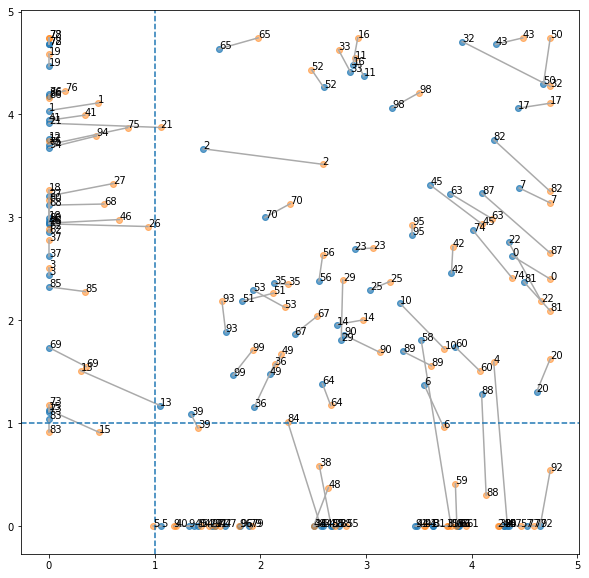

In [122]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
# print(itemz.shape,chosen.shape)
# itemz_2 = pca.fit_transform(itemz_2)
# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
#do not use by mistake # itemz_pred = pca2.fit_transform(itemz_pred)
# itemz_pred = pca.transform(itemz_pred)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))

fig.gca().axvline(x=baseline, linestyle="--")
fig.gca().axhline(y=baseline, linestyle="--")
    
fig.show()

In [ ]:
psi_wgts = s_table.get_weights()[0]
print(psi_wgts)
for psi in ss:
    print(psi.id, psi.thetas, psi_wgts[psi.id])
print("qs ====")
qn_wgts = q_table.get_weights()[0]
print(qn_wgts)
for qn in qs:
    print(qn.id, qn.betas, qn_wgts[qn.id])

In [ ]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 250
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [ ]:
xs = range(len(serieses[0][0]))
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=1, ncols=2)
print(axes.shape)

min_mses = []
max_accs = []
bmin_mses = []
bmax_accs = []

for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    mm = min(th_mses)
    ma = max(th_accs)
    min_mses.append(mm)
    max_accs.append(ma)
    mm = min(b_mses)
    ma = max(b_accs)
    bmin_mses.append(mm)
    bmax_accs.append(ma)
    

axes[0].plot(nn_dimensions, numpy.multiply(1,min_mses))
axes[0].plot(nn_dimensions, numpy.multiply(1,bmin_mses))
axes[1].plot(nn_dimensions, numpy.multiply(1,max_accs))
axes[1].plot(nn_dimensions, numpy.multiply(1,bmax_accs))
axes[0].axvline(x=5, linestyle="--")
axes[1].axvline(x=5, linestyle="--")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18,4)

fig.show()